# Deep Learning Inference

- Most commercial deep learning applications today use 32-bits of floating point precision for training and inference workloads.

- Lower numerical precision inference and training can improve the computational performance with minimal or no reduction in statistical accuracy.

- Many operations are memory bandwidth bound, and reducing precision would allow for better usage of cache and reduction of bandwidth bottlenecks

- Intel is enabling 8-bit precision for inference on the current generation of Intel Xeon Scalable processors.

- Intel is also enabling 8-bit precision for inference and 16-bit precision for training on future microarchitectures in both hardware and software enabling compilers, the Intel MKL-DNN library and popular deep learning frameworks.

Reference:

- https://software.intel.com/en-us/articles/lower-numerical-precision-deep-learning-inference-and-training

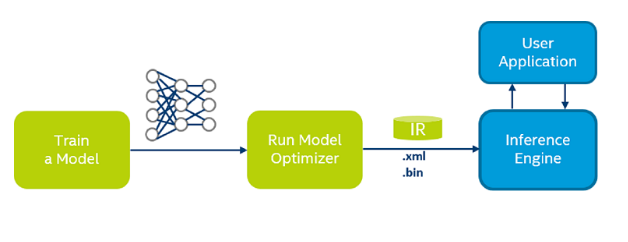

In [11]:
from IPython.display import Image
Image("model_optimized.png", width=600, height=600)

# Usability issues

- Conversion from a trained model requires many dependencies, obscure scripts and some metadata from model. The same for Inference engine.
- Appending these nodes to a current workflow is not direct.


# Tiny simulation demo

In [1]:
%%time

from scanflow.setup import Setup, Executor, Tracker, Workflow
from scanflow.deploy import Deploy

# App folder
app_dir = '/home/guess/Desktop/scanflow/examples/intel_openvino/data-science/'

executors1 = [Executor(name='modeling1', 
                      file='modeling1.py',
                      parameters={'preprocessed_data': 'preprocessed_data.csv',
                                  'model_path': 'models',
                                  'n_estimators': 3},
                      env='modeling'),
              
              Executor(name='inference', 
                       file='inference.py',
                       parameters={'data': 'image.png',
                                   'model': 'model_optimized.xml'},
                       requirements='req_modeling.txt')]

workflow1 = Workflow(name='workflow1', 
                     executors=executors1,
                     tracker=Tracker(port=8001))

executors2 = [Executor(name='modeling2', 
                      file='modeling2.py',
                      parameters={'preprocessed_data': 'preprocessed_data.csv',
                                  'model_path': 'models',
                                  'n_estimators': 3},
                      env='modeling'),
              
              Executor(name='optimizer', 
                       file='optimizer.py',
                       parameters={'model_in': 'model.caffe',
                                  'model_out': 'model_optimized.xml'},
                       requirements='req_modeling.txt'),
              
              Executor(name='inference_intel', 
                       file='inference_intel.py',
                       parameters={'data': 'image.png',
                                   'model': 'model_optimized.xml'},
                       requirements='req_modeling.txt')]
# Parallel
workflow2 = Workflow(name='workflow2', 
                     executors=executors2,
                     tracker=Tracker(port=8002))

workflower = Setup(app_dir, workflows=[workflow1, workflow2],
                             verbose=False)

# Build the nodes
workflower.build_workflows()

# Start containers and run workflows
deployer = Deploy(app_dir, workflower, verbose=True)

deployer.start_workflows()
deployer.run_workflows()

  0%|          | 0/2 [00:00<?, ?it/s]27-Mar-20 11:27:21 -  INFO - [++] Starting workflow: [workflow1].
27-Mar-20 11:27:21 -  WARNING - [+] Network: [network_workflow1] is already running.
27-Mar-20 11:27:21 -  INFO - [+] Starting env: [workflow1:modeling1].
27-Mar-20 11:27:21 -  WARNING - [+] Environment: [modeling1] is already running.
27-Mar-20 11:27:21 -  INFO - [+] Starting env: [workflow1:inference].
27-Mar-20 11:27:21 -  WARNING - [+] Environment: [inference] is already running.
27-Mar-20 11:27:21 -  INFO - [+] Starting env: [tracker-workflow1:inference].
27-Mar-20 11:27:21 -  WARNING - [+] Environment: [tracker-workflow1] is already running.
27-Mar-20 11:27:21 -  INFO - [+] Workflow: [workflow1] was started successfully.
27-Mar-20 11:27:21 -  INFO - [++] Starting workflow: [workflow2].
27-Mar-20 11:27:21 -  WARNING - [+] Network: [network_workflow2] is already running.
27-Mar-20 11:27:21 -  INFO - [+] Starting env: [workflow2:modeling2].
27-Mar-20 11:27:21 -  WARNING - [+] Envir

CPU times: user 1.35 s, sys: 155 ms, total: 1.5 s
Wall time: 12.2 s


In [13]:
# workflower.stop_workflows()

## Graph

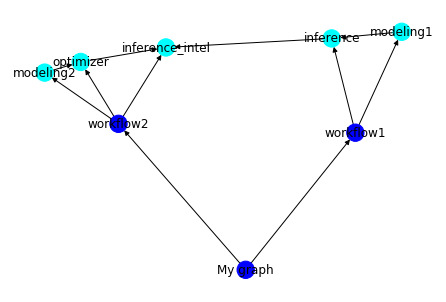

In [3]:
workflower.draw_workflow('My graph')

## Running containers

In [4]:
%%bash

docker ps --format '{{.Names}}'

tracker-workflow2
inference_intel
optimizer
modeling2
tracker-workflow1
inference
modeling1
objective_dubinsky


## Tracking

In [9]:
from scanflow.track import Tracker

tracker = Tracker(app_dir)
# tracker.open_browser('workflow1')
df = tracker.get_tracked_values(workflow_name='workflow1')
df.head(2)

,end_time,metrics.test_acc,params.data_in,params.data_out,params.model_in,params.n_estimators_model,params.random_state_model,params.random_state_split,params.test_percentage,params.x_test_len,params.x_train_len,run_id,start_time,tags.mlflow.runName,tags.mlflow.source.name
0,2020-03-27 10:27:25.480000+00:00,NaN,image.png,out_image.png.bmp,model_optimized.xml,None,None,None,None,None,None,2c68a84d45d3413a8bfcd9872f9f1657,2020-03-27 10:27:24.817000+00:00,inference,inference.py
1,2020-03-27 10:27:23.484000+00:00,0.647,None,None,None,3,42,42,0.2,68,272,87a3c6b04c2a4959800787dfe79a5102,2020-03-27 10:27:23.331000+00:00,modeling1,modeling1.py


In [10]:
df = tracker.get_tracked_values(workflow_name='workflow2')
df.head(3)

,end_time,metrics.test_acc,params.data_in,params.data_out,params.model_in,params.model_out,params.n_estimators_model,params.random_state_model,params.random_state_split,params.test_percentage,params.x_test_len,params.x_train_len,run_id,start_time,tags.mlflow.runName,tags.mlflow.source.name
0,2020-03-27 10:27:31.530000+00:00,NaN,image.png,out_image.png.bmp,model_optimized.xml,None,None,None,None,None,None,None,b0c0cf645bee4b5dadd749e4a6f6ef16,2020-03-27 10:27:31.152000+00:00,inference_intel,inference_intel.py
1,2020-03-27 10:27:29.806000+00:00,NaN,None,None,model.caffe,model_optimized.xml,None,None,None,None,None,None,6a9609624f5e4be2878aa52374bd99ae,2020-03-27 10:27:28.663000+00:00,optimizer,optimizer.py
2,2020-03-27 10:27:27.222000+00:00,0.647,None,None,None,None,3,42,42,0.2,68,272,0c2db42370424cfabeff624fe69a90ef,2020-03-27 10:27:27.094000+00:00,modeling2,modeling2.py


# Proposal

**TODO**

- Transitional interfaces between states (e.g, the arrows in: model -> optimized_model -> inference),
    in order to make it simpler.
3.  Transitional interfaces for [inference - Checking] and [inference - Interact] modules.

**Benefits**:

1. Standarization of communication between nodes, therefore, converting a model without much effort.
2. Flexibility to choose which workflow to run: a workflow that best fit a certain platform, such as desktop, car, raspberry pi, etc. For instance:

 ```python
 if device is typeA:
     run workflow A, 
 elif (device is typeB):
     run workflow B1 or run workflow B2
 else 
     run workflow C1 then run workflow C2 then workflow C3
 ```
 
 
3. Depending on traffic, switch models. For example:
 ```python
 if inference_time is critical:
     pick model A, 
 elif (accuracy is critical) 
     pick model B 
 else pick model  C
 ```

# Appendix

### Optimizer

python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model /opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/public/mobilenet-ssd/mobilenet-ssd.caffemodel --input_proto /opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/public/mobilenet-ssd/mobilenet-ssd.prototxt --data_type FP16


### Inference

python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model /opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/public/mobilenet-ssd/mobilenet-ssd.caffemodel --input_proto /opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/public/mobilenet-ssd/mobilenet-ssd.prototxt --data_type FP16
